In [1]:
import os
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation, SegformerForSemanticSegmentation, SamModel, SamProcessor
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

/home/bearceb/.pyenv/versions/3.10.4/envs/MedSAM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Show Image

In [2]:
# image = example['pixel_values']
# raw_image = Image.open('/scratch/alpine/skinder@xsede.org/glaucoma_segmentation_data/seg_public_all_vtwo/images/drishtiGS_054.png') # Scott
raw_image = Image.open('/sddata/data/MedSAM/public_test_data_01_10_2023/Color_Fundus/visivite_GA.png')
# Convert RGBA image to RGB
raw_image = raw_image.convert("RGB")

In [3]:
np.array(raw_image)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [4]:
np.array(raw_image).shape

(1811, 2039, 3)

In [15]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = "cpu"

model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base").to(device)
# model = torch.load("/sddata/data/MedSAM/model/flaviagiammarino_medsam-vit-base-model.pt").to(device)
processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

# img_url = "https://huggingface.co/flaviagiammarino/medsam-vit-base/resolve/main/scripts/input.png"
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")


In [16]:
processor

SamProcessor:
- image_processor: SamImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": false,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0,
    0,
    0
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    1,
    1,
    1
  ],
  "mask_pad_size": {
    "height": 256,
    "width": 256
  },
  "mask_size": {
    "longest_edge": 256
  },
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}


{
  "processor_class": "SamProcessor"
}

In [29]:
model.config
# model.state_dict()

SamConfig {
  "_name_or_path": "flaviagiammarino/medsam-vit-base",
  "architectures": [
    "SamModel"
  ],
  "initializer_range": 0.02,
  "mask_decoder_config": {
    "model_type": ""
  },
  "model_type": "sam",
  "prompt_encoder_config": {
    "model_type": ""
  },
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vision_config": {
    "dropout": 0.0,
    "initializer_factor": 1.0,
    "intermediate_size": 6144,
    "model_type": "",
    "projection_dim": 512
  }
}

In [18]:
# torch.save(model.state_dict(), "/sddata/data/MedSAM/model/flaviagiammarino_medsam-vit-base-state-dict.pt")
# torch.save(model, "/sddata/data/MedSAM/model/flaviagiammarino_medsam-vit-base-model.pt")

In [19]:
raw_image_np = np.array(raw_image)
raw_image_np.shape # (1811, 2039, 3)
# Define transformations (resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize the image and mask to the desired input size
    # transforms.Resize((512, 512)),  # Resize the image and mask to the desired input size
    transforms.ToTensor(),           # Convert PIL Image to tensor
])

t_raw_image_np = transform(raw_image)
t_raw_image_np = t_raw_image_np.permute(1, 2, 0)
print(np.array(raw_image).shape)
print(t_raw_image_np.shape)



(1811, 2039, 3)
torch.Size([1024, 1024, 3])


# Inference

In [20]:
input_boxes = [600., 600., 1200., 1400.] # [x1, y1, x2, y2] (1811, 2039, 3)
# input_boxes = [300., 400., 600., 800.] # [x1, y1, x2, y2] torch.Size([1024, 1024, 3])
# input_boxes = [0., 0., 512., 512.]
inputs = processor(raw_image, input_boxes=[[input_boxes]], return_tensors="pt").to(device)
# inputs = processor(t_raw_image_np, input_boxes=[[input_boxes]], return_tensors="pt").to(device)
inputs
outputs = model(**inputs, multimask_output=False)
# outputs
probs = processor.image_processor.post_process_masks(
    outputs.pred_masks.sigmoid().cpu(), 
    inputs["original_sizes"].cpu(), 
    inputs["reshaped_input_sizes"].cpu(), binarize=False)


In [21]:
probs[0].shape

torch.Size([1, 1, 1811, 2039])

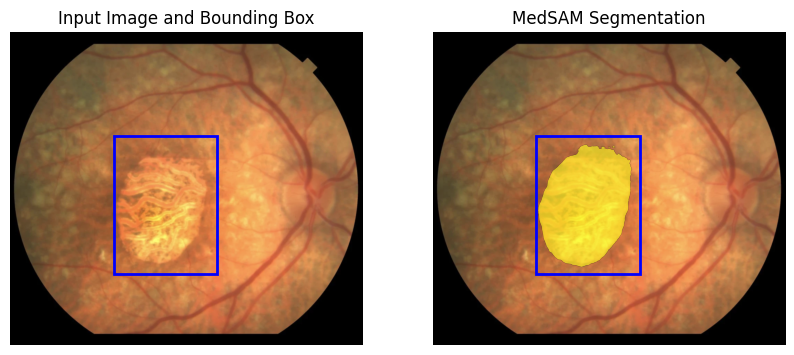

In [23]:
def show_mask(mask, ax, random_color):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.array(raw_image))
# ax[0].imshow(np.array(t_raw_image_np))
show_box(input_boxes, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[0].axis("off")
ax[1].imshow(np.array(raw_image))
# ax[1].imshow(np.array(t_raw_image_np))
show_mask(mask=probs[0] > 0.5, ax=ax[1], random_color=False)
show_box(input_boxes, ax[1])
ax[1].set_title("MedSAM Segmentation")
ax[1].axis("off")
plt.show()

In [24]:
print(outputs.pred_masks.sigmoid().cpu())
print(inputs["original_sizes"].cpu())
print(inputs["reshaped_input_sizes"].cpu())
probs = processor.image_processor.post_process_masks(
    outputs.pred_masks.sigmoid().cpu(), 
    inputs["original_sizes"].cpu(), 
    inputs["reshaped_input_sizes"].cpu(), binarize=False)

print(probs)

tensor([[[[[2.3248e-07, 5.1729e-07, 2.5222e-07,  ..., 4.7820e-07,
            1.7243e-07, 1.4161e-07],
           [1.3043e-07, 2.3237e-07, 1.7369e-07,  ..., 2.7815e-07,
            1.8496e-07, 1.1253e-07],
           [2.1846e-07, 2.5904e-07, 3.0424e-07,  ..., 2.6877e-07,
            2.1106e-07, 2.0671e-07],
           ...,
           [2.1165e-07, 1.9277e-07, 3.0049e-07,  ..., 1.6507e-07,
            2.5636e-07, 1.6465e-07],
           [3.0467e-07, 2.7119e-07, 2.8160e-07,  ..., 3.0185e-07,
            2.6011e-07, 2.6367e-07],
           [2.0353e-07, 1.1366e-07, 1.2834e-07,  ..., 1.4121e-07,
            1.2017e-07, 1.3183e-07]]]]], grad_fn=<SigmoidBackward0>)
tensor([[1811, 2039]])
tensor([[ 909, 1024]])
[tensor([[[[2.3248e-07, 2.3248e-07, 2.3248e-07,  ..., 1.4161e-07,
           1.4161e-07, 1.4161e-07],
          [2.3248e-07, 2.3248e-07, 2.3248e-07,  ..., 1.4161e-07,
           1.4161e-07, 1.4161e-07],
          [2.3248e-07, 2.3248e-07, 2.3248e-07,  ..., 1.4161e-07,
           1.4161e-0

# Training

In [25]:
# Define your dataset class
class ImageMaskDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask

In [28]:
# Define your model
# model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")
model = torch.load("/sddata/data/MedSAM/model/flaviagiammarino_medsam-vit-base-model.pt")
# Modify the model's output layer for segmentation task
# For example, for binary segmentation, you can use a sigmoid activation
model.config
# model.classifier = nn.Sequential(
#     nn.Linear(model.config.vision_config.projection_dim, 1),
#     nn.Sigmoid()
# )

SamConfig {
  "_name_or_path": "flaviagiammarino/medsam-vit-base",
  "architectures": [
    "SamModel"
  ],
  "initializer_range": 0.02,
  "mask_decoder_config": {
    "model_type": ""
  },
  "model_type": "sam",
  "prompt_encoder_config": {
    "model_type": ""
  },
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "vision_config": {
    "dropout": 0.0,
    "initializer_factor": 1.0,
    "intermediate_size": 6144,
    "model_type": "",
    "projection_dim": 512
  }
}

In [30]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [31]:
# Prepare your dataset and dataloaders
train_image = Image.open('/sddata/data/MedSAM/public_test_data_01_10_2023/Color_Fundus/visivite_GA.png')
train_mask = Image.open('/sddata/data/MedSAM/public_test_data_01_10_2023/labels/visivite_GA.png')

val_image = Image.open('/sddata/data/MedSAM/public_test_data_01_10_2023/Color_Fundus/76_year_old_GA.png')
val_mask = Image.open('/sddata/data/MedSAM/public_test_data_01_10_2023/labels/76_year_old_GA.png')


In [32]:
train_image_np = np.array(train_image)
train_mask_np = np.array(train_mask)

val_image_np = np.array(val_image)
val_mask_np = np.array(val_mask)

In [33]:
print(train_image_np.shape)
print(train_mask_np.shape)
print(val_image_np.shape)
print(val_mask_np.shape)


(1811, 2039, 4)
(1811, 2039, 4)
(1370, 1397, 4)
(1370, 1397, 4)


In [34]:
train_image_np[:,:,0] # R
# train_image_np[:,:,1] # G
# train_image_np[:,:,2] # B
# train_image_np[:,:,3] # alpha

# train_image_np[500,500,0] # R pixel at 500, 500
# train_image_np[500,500,1]# G pixel at 500, 500
# train_image_np[500,500,2]# B pixel at 500, 500
# train_image_np[500,500,3]# A pixel at 500, 500

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
# Define transformations (resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize the image and mask to the desired input size
    transforms.ToTensor(),           # Convert PIL Image to tensor
])

In [36]:
# Apply transformations to image and mask
train_image = transform(train_image)
train_mask = transform(train_mask)
train_mask = (train_mask > 0.5).float()

val_image = transform(val_image)
val_mask = transform(val_mask)
val_mask = (val_mask > 0.5).float()

# Add batch dimension to image and mask
train_image = train_image.unsqueeze(0)  # Add batch dimension
train_mask = train_mask.unsqueeze(0)    # Add batch dimension

val_image = val_image.unsqueeze(0)  # Add batch dimension
val_mask = val_mask.unsqueeze(0)    # Add batch dimension

In [37]:
image_t = train_image[:,0:3,:,:]
mask_t = train_mask[:,3,:,:].unsqueeze(1)

image_v = val_image[:,0:3,:,:]
mask_v = val_mask[:,3,:,:].unsqueeze(1)

In [38]:
# Check the shapes
print("Train Image shape:", image_t.shape)  # Should be (1, 3, 224, 224) if RGB image
print("Train Mask shape:", mask_t.shape)    # Should be (1, 1, 224, 224) if single-channel mask

print("Val Image shape:", image_v.shape)  # Should be (1, 3, 224, 224) if RGB image
print("Val Mask shape:", mask_v.shape)    # Should be (1, 1, 224, 224) if single-channel mask

Train Image shape: torch.Size([1, 3, 1024, 1024])
Train Mask shape: torch.Size([1, 1, 1024, 1024])
Val Image shape: torch.Size([1, 3, 1024, 1024])
Val Mask shape: torch.Size([1, 1, 1024, 1024])


In [39]:
train_dataset = ImageMaskDataset(image_t, mask_t)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = ImageMaskDataset(image_v, mask_v)
val_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [40]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

        val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pth")